In [34]:
!./install.sh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.0 MB/s  0:00:02 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [35]:
import json
import spacy
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path
from torchtext import data, datasets
from torchtext.vocab import GloVe
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
from utils.config import Config
from utils.helper import get_context_average_embedding

In [36]:
TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths=True)
LABEL = data.LabelField()

train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

In [37]:
train_data, valid_data = train_data.split(random_state=random.seed(Config.SEED), split_ratio=0.8)

In [38]:
print(f"Train size: {len(train_data)}")
print(f"Valid size: {len(valid_data)}")
print(f"Test size: {len(test_data)}")

Train size: 4362
Valid size: 1090
Test size: 500


In [39]:
glove = GloVe(name='6B', dim=Config.EMBEDDING_DIM)

## PART 1
As the first step of building your model, you need to prepare the word embeddings using the
pre-trained vectors to form the input layer of your model. You are required to choose only from
Word2vec or Glove to initialize your word embedding matrix. The word embedding matrix stores
the pre-trained word vectors (taken from Word2vec or Glove) where each row corresponds to a vector
for a specific word in the vocabulary formed from your task dataset.

### (a)
What is the size of the vocabulary formed from your training data according to your tokenization method?

In [40]:
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)
vocab_size = len(TEXT.vocab)

print(f"Size of Vocabulary from training data using spacy tokenizer: {vocab_size}")
print(f"Number of classes: {len(LABEL.vocab)}")
print(f"Class labels: {dict(LABEL.vocab.stoi)}")

Size of Vocabulary from training data using spacy tokenizer: 8093
Number of classes: 6
Class labels: {'HUM': 0, 'ENTY': 1, 'DESC': 2, 'NUM': 3, 'LOC': 4, 'ABBR': 5}


In [41]:
TEXT.build_vocab(train_data, vectors="glove.6B.300d")
LABEL.build_vocab(train_data)
vocab_size = len(TEXT.vocab)

print(f"Size of Vocabulary from training data using spacy tokenizer: {vocab_size}")
print(f"Number of classes: {len(LABEL.vocab)}")
print(f"Class labels: {dict(LABEL.vocab.stoi)}")

Size of Vocabulary from training data using spacy tokenizer: 8093
Number of classes: 6
Class labels: {'HUM': 0, 'ENTY': 1, 'DESC': 2, 'NUM': 3, 'LOC': 4, 'ABBR': 5}


### (b)
We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but
not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?
What is the number of OOV words for each topic category?

In [42]:
oov_per_category = defaultdict(set)
word_category_map = defaultdict(set)
oov = set()

for example in train_data.examples:
    category = example.label
    for word in example.text:
        if word not in glove.stoi:
          oov.add(word)
          if word not in oov_per_category[category]:
            oov_per_category[category].add(word)

print(f"Total OOV words: {len(oov)}")
print("OOV words per category:")
for category in sorted(oov_per_category.keys()):
    unique_oovs = len(oov_per_category[category])
    print(f"  {category}: {unique_oovs} unique OOV words")

Total OOV words: 3161
OOV words per category:
  ABBR: 60 unique OOV words
  DESC: 621 unique OOV words
  ENTY: 896 unique OOV words
  HUM: 1331 unique OOV words
  LOC: 735 unique OOV words
  NUM: 641 unique OOV words


### (c)
The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove).
Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you
think is the best strategy to mitigate such limitation? Implement your solution in your source
code. Show the corresponding code snippet.

For our Out-of-Vocabulary (OOV) word strategy, we selected the Contextual Average method. This approach generates a vector for an OOV word by calculating the mean of the embeddings of its surrounding words in a given sentence. We chose this method because word meaning is heavily dependent on context, making this a versatile and accurate approximation.

In [43]:
embedding_matrix = np.zeros((vocab_size, Config.EMBEDDING_DIM))

index_from_word = {word: index for index, word in enumerate(TEXT.vocab.itos)}

for example in train_data.examples:
    for word in example.text:
        index = index_from_word[word]
        if word not in glove.stoi and word in index_from_word:
            embedding_matrix[index] = get_context_average_embedding(example.text, word, glove)
        else:
            embedding_matrix[index] = glove.vectors[glove.stoi[word]].numpy()

            

In [44]:
# unk token
embedding_matrix[0] = np.random.normal(scale=0.6, size=(Config.EMBEDDING_DIM,))

In [45]:
# Export Embedding Matrix and Vocab Index Mapping (train data)
embedding_path = Path("models/embedding_matrix.npy")
index_from_word_path = Path("models/index_from_word.json")

embedding_path.parent.mkdir(parents=True, exist_ok=True)

np.save(embedding_path, embedding_matrix)

with index_from_word_path.open("w") as f:
    json.dump(index_from_word, f)

### (d)
Select the 20 most frequent words from each topic category in the training set (removing
stopwords if necessary). Retrieve their pretrained embeddings (from Word2Vec or GloVe).
Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis).
Plot the points in a scatter plot, color-coded by their topic category. Attach your plot here.
Analyze your findings

In [46]:
def get_top_words_per_topic(train_data, label_vocab, n=20):
    """Get top N frequent words per topic (excluding stopwords)"""
    nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
    stopwords = nlp.Defaults.stop_words

    topic_words = {label: [] for label in label_vocab.itos}

    for example in train_data.examples:
        topic = example.label
        for word in example.text:
            if word.lower() not in stopwords and len(word) > 2:
                topic_words[topic].append(word.lower())

    top_words = {}
    for topic, words in topic_words.items():
        counter = Counter(words)
        top_words[topic] = [word for word, _ in counter.most_common(n)]

    return top_words


def visualize_embeddings(vocab, top_words, label_vocab, method='tsne', seed=42):
    """Visualize word embeddings in 2D using t-SNE or PCA"""
    words_to_plot = []
    labels_to_plot = []
    vectors_to_plot = []

    for topic, words in top_words.items():
        for word in words:
            if word in vocab.stoi:
                words_to_plot.append(word)
                labels_to_plot.append(topic)
                # Convert to numpy if using torch tensor (GloVe)
                vector = vocab.vectors[vocab.stoi[word]]
                if hasattr(vector, 'numpy'):
                    vector = vector.numpy()
                vectors_to_plot.append(vector)

    vectors_array = np.array(vectors_to_plot)

    # Dimensionality reduction
    if method.lower() == 'tsne':
        print("Applying t-SNE for dimensionality reduction...")
        reducer = TSNE(n_components=2, random_state=Config.SEED, perplexity=min(30, len(vectors_array)-1))
    elif method.lower() == 'pca':
        print("Applying PCA for dimensionality reduction...")
        reducer = PCA(n_components=2, random_state=Config.SEED)
    else:
        raise ValueError("method must be 'tsne' or 'pca'")

    embeddings_2d = reducer.fit_transform(vectors_array)

    # Plot
    plt.figure(figsize=(14, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, len(label_vocab)))

    labels_array = np.array(labels_to_plot)
    for i, topic in enumerate(label_vocab.itos):
        mask = labels_array == topic
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[colors[i]],
            label=topic,
            alpha=0.7,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )

    plt.legend(loc='best', fontsize=10, framealpha=0.9)
    plt.title(f'Word Embeddings Visualization ({method.upper()}) - Top 20 Words per Topic', fontsize=14)
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # plt.savefig(f'q1d_word_embeddings_{method}.png', dpi=300, bbox_inches='tight')
    # print(f"Saved visualization to 'q1d_word_embeddings_{method}.png'")
    plt.show()


In [47]:
print("Extracting top words per topic...")
top_words = get_top_words_per_topic(train_data, LABEL.vocab, n=20)
print(f"Extracted top 20 words for {len(top_words)} topics")

for topic, words in top_words.items():
    print(f"{topic}: {', '.join(words)}")

Extracting top words per topic...
Extracted top 20 words for 6 topics
HUM: president, company, world, wrote, famous, u.s., won, invented, team, baseball, actor, portrayed, star, movie, american, known, man, new, said, character
ENTY: fear, kind, called, world, film, color, book, movie, best, novel, word, game, drink, known, war, animal, english, term, play, sport
DESC: mean, origin, word, difference, find, come, work, term, causes, meaning, people, makes, like, famous, happened, computer, u.s., school, know, definition
NUM: year, long, people, average, world, day, population, old, war, american, u.s., cost, number, live, game, years, born, time, earth, big
LOC: country, city, world, state, u.s., find, largest, countries, river, located, highest, island, capital, information, live, american, south, states, america, airport
ABBR: stand, abbreviation, mean, national, bureau, investigation, ioc, form, cnn, cpr, abbreviated, acronym, general, motors, letters, r.e.m., equation, mc2, p.m., d.

Applying PCA for dimensionality reduction...


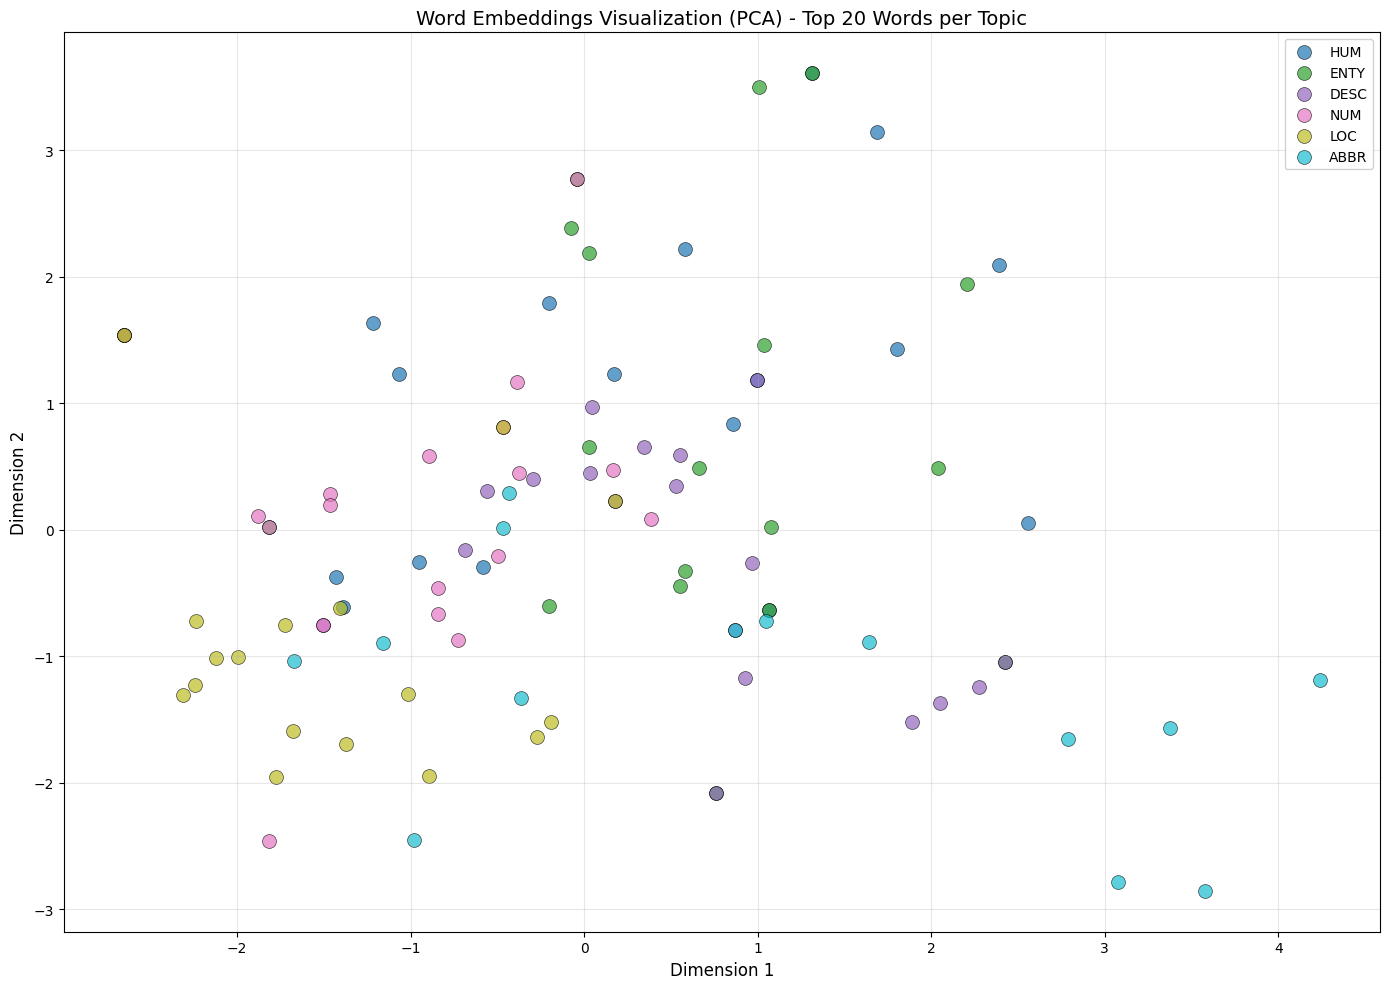

In [48]:
TEXT.vocab.vectors = embedding_matrix
visualize_embeddings(TEXT.vocab, top_words, LABEL.vocab, method='pca')


Ans:
This visualization suggests that the pre-trained embeddings are working well, capturing semantic meaning as expected. It also highlights a key challenge for the classification task: Categories with specific, unique vocabularies (LOC, ABBR) will likely be easier to classify. Categories that are broad (ENTY) or defined by generic, functional words (DESC, NUM) will be much harder to distinguish, as their top words are semantically ambiguous and overlap heavily with all other topics.